# Multivariate Decoding Analysis for Neural Replay

Based on **Liu et al. (2019) Cell**: *Human Replay Spontaneously Reorganizes Experience*

This notebook demonstrates the multivariate decoding algorithm for detecting sequential replay of neural representations during rest periods.

## Key Concepts

1. **Stimulus Decoders**: Train classifiers to recognize neural patterns associated with each stimulus
2. **Reactivation Detection**: Apply decoders to rest periods to detect spontaneous reactivations
3. **Sequenceness Measure**: Quantify the degree to which reactivations follow a sequential structure
4. **Statistical Testing**: Use permutation tests to establish significance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns

# Import the replay_decoder package
from replay_decoder import (
    MultivariateReplayDecoder,
    create_linear_transition_matrix,
    plot_sequenceness
)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Part 1: Example 1 - Basic Simulation with Forward Replay

We'll simulate a simple scenario:
- 4 states: A, B, C, D
- Sequence: A → B → C → D
- Replay lag: 40ms (as in the paper)

The `MultivariateReplayDecoder` class is imported from the `replay_decoder` package.

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Parameters
n_trials = 200
n_timepoints_per_trial = 50  # 500ms at 100Hz
n_sensors = 100
n_states = 4

print("Creating simulated training data with null/fixation periods...")
print(f"  - {n_trials} trials")
print(f"  - {n_states} states (A, B, C, D)")
print(f"  - {n_sensors} sensors")
print(f"  - {n_timepoints_per_trial} timepoints per trial (500ms)")

# Simulate training data (functional localizer)
# Each trial has fixation period (first 10 timepoints) then stimulus (rest of trial)
X_train = np.random.randn(n_trials, n_timepoints_per_trial, n_sensors) * 0.5
y_train = np.random.randint(0, n_states, n_trials)

# Add signal at 200ms for each state
time_idx = 20  # 200ms
for trial in range(n_trials):
    state = y_train[trial]
    # Add state-specific pattern to specific sensors
    X_train[trial, time_idx, state*10:(state+1)*10] += 2.0

# Create null/fixation data from pre-stimulus period (first 100ms = 10 timepoints)
# This represents baseline activity before stimulus onset
n_null_samples = n_trials  # Same number as stimulus trials
X_null = X_train[:, :10, :].reshape(n_null_samples * 10, n_sensors)  # Flatten time dimension
# Take subset to match trial count
X_null = X_null[:n_null_samples, :]
y_null = np.full(n_null_samples, n_states)  # Label as state n_states (null state)

print(f"\nNull/fixation data extracted from pre-stimulus period:")
print(f"  - Shape: {X_null.shape}")
print(f"  - Label: {n_states} (null state)")

# Combine stimulus data with null data for training
# Extract stimulus timepoint for training
X_stim_at_time = X_train[:, time_idx, :]  # shape: (n_trials, n_sensors)

# Stack stimulus and null data
X_train_augmented = np.vstack([X_stim_at_time, X_null])
y_train_augmented = np.concatenate([y_train, y_null])

print(f"\nAugmented training data created:")
print(f"  - Stimulus trials: {n_trials}")
print(f"  - Null trials: {n_null_samples}")
print(f"  - Total shape: {X_train_augmented.shape}")
print(f"  - This includes null data as negative examples for classifiers")

Creating simulated training data with null/fixation periods...
  - 200 trials
  - 4 states (A, B, C, D)
  - 100 sensors
  - 50 timepoints per trial (500ms)

Null/fixation data extracted from pre-stimulus period:
  - Shape: (200, 100)
  - Label: 4 (null state)

Augmented training data created:
  - Stimulus trials: 200
  - Null trials: 200
  - Total shape: (400, 100)
  - This includes null data as negative examples for classifiers


/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_56778/2411793597.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[state].set_xticklabels([int(x*10) for x in xticks])
/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_56778/2411793597.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[state].set_xticklabels([int(x*10) for x in xticks])
/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_56778/2411793597.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[state].set_xticklabels([int(x*10) for x in xticks])
/var/folders/6z/lrk02sv52pn2vqxpttkyq1m00000gn/T/ipykernel_56778/2411793597.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or u

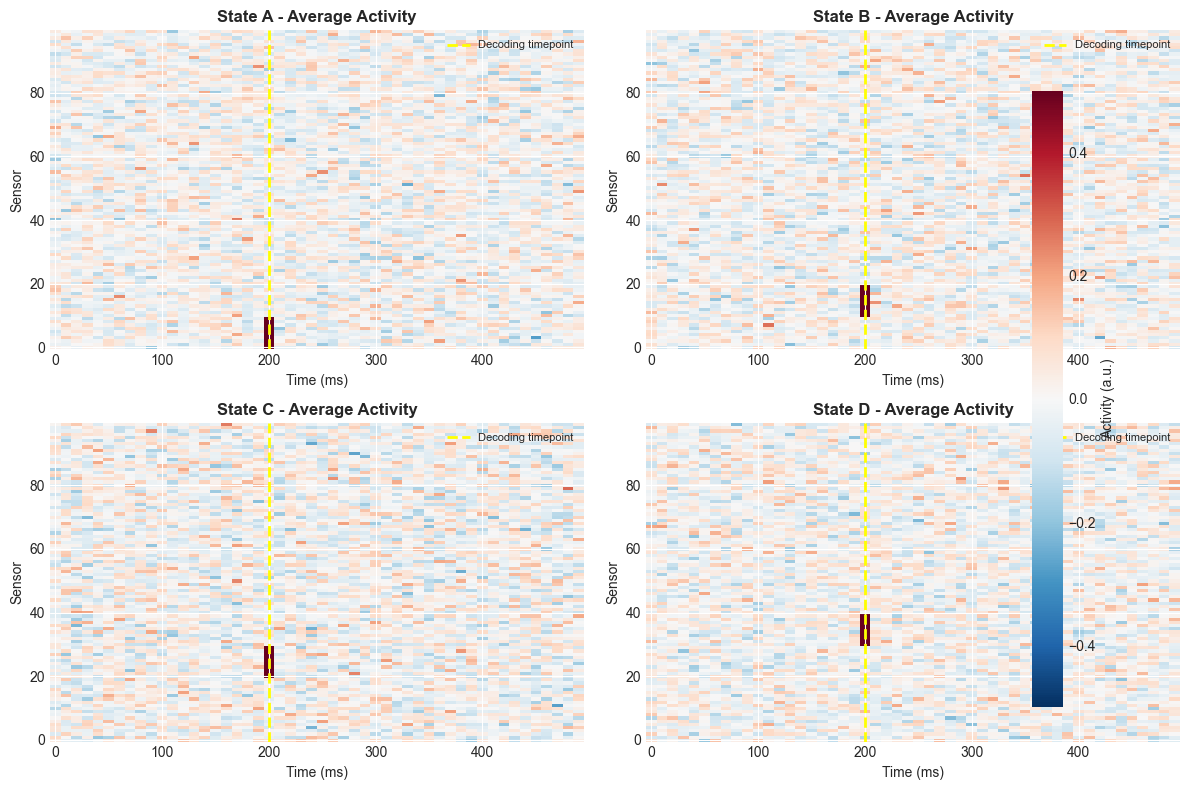

Training data visualization saved!


In [3]:
# Visualize training data
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

state_names = ['A', 'B', 'C', 'D']
for state in range(n_states):
    # Get trials for this state
    state_trials = X_train[y_train == state]

    # Average across trials and plot
    avg_activity = state_trials.mean(axis=0)  # (timepoints, sensors)

    im = axes[state].imshow(avg_activity.T, aspect='auto', cmap='RdBu_r',
                            vmin=-0.5, vmax=0.5, origin='lower')
    axes[state].set_xlabel('Time (ms)', fontsize=10)
    axes[state].set_ylabel('Sensor', fontsize=10)
    axes[state].set_title(f'State {state_names[state]} - Average Activity', fontsize=12, fontweight='bold')
    axes[state].axvline(x=20, color='yellow', linestyle='--', linewidth=2, label='Decoding timepoint')
    axes[state].legend(loc='upper right', fontsize=8)

    # Set x-axis labels in milliseconds
    xticks = axes[state].get_xticks()
    axes[state].set_xticklabels([int(x*10) for x in xticks])

plt.colorbar(im, ax=axes, label='Activity (a.u.)', fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig('training_data_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training data visualization saved!")

In [4]:
# Initialize and train decoder
print("Initializing decoder...")
decoder = MultivariateReplayDecoder(n_states=n_states, max_lag_ms=600, sampling_rate=100)

print("\nTraining classifiers with augmented data (includes null state)...")
# We need to reshape our 2D augmented data back to 3D format for compatibility
# Create a 3D array with single timepoint
X_train_3d = X_train_augmented[:, np.newaxis, :]  # shape: (n_samples, 1, n_sensors)

# Train with timepoint 0 (since we only have 1 timepoint)
decoder.train_classifiers(X_train_3d, y_train_augmented, time_point_ms=0, C=1.0)

print("\nEach binomial classifier was trained on:")
print(f"  - Positive examples: trials when that specific state was presented")
print(f"  - Negative examples: trials of other states + null/fixation data")
print(f"  - This follows the paper's approach to reduce classifier correlation")

# Evaluate decoder performance with cross-validation
print("\nEvaluating decoder performance (cross-validation on stimulus trials only)...")

for state in range(n_states):
    y_binary = (y_train_augmented == state).astype(int)
    scores = cross_val_score(decoder.classifiers[state],
                            decoder.scalers[state].transform(X_train_augmented),
                            y_binary, cv=5, scoring='roc_auc')
    print(f"  State {state_names[state]}: AUC = {scores.mean():.3f} ± {scores.std():.3f}")

Initializing decoder...

Training classifiers with augmented data (includes null state)...

Each binomial classifier was trained on:
  - Positive examples: trials when that specific state was presented
  - Negative examples: trials of other states + null/fixation data
  - This follows the paper's approach to reduce classifier correlation

Evaluating decoder performance (cross-validation on stimulus trials only)...
  State A: AUC = 1.000 ± 0.000
  State B: AUC = 1.000 ± 0.000
  State C: AUC = 1.000 ± 0.000
  State D: AUC = 1.000 ± 0.000


/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_rat

In [5]:
# Simulate resting state data with embedded replay
print("Simulating resting state with replay sequence A→B→C→D...")
n_rest_timepoints = 3000  # 30 seconds at 100Hz
X_rest = np.random.randn(n_rest_timepoints, n_sensors) * 0.3

# Embed sequence A→B→C→D at 40ms lag, at multiple time points
lag_samples = 4  # 40ms at 100Hz
sequence = [0, 1, 2, 3]  # A→B→C→D
replay_times = []

for start_time in range(100, n_rest_timepoints - 100, 200):
    replay_times.append(start_time)
    for step, state in enumerate(sequence):
        time_point = start_time + step * lag_samples
        if time_point < n_rest_timepoints:
            # Add signal to state-specific sensors
            X_rest[time_point, state*10:(state+1)*10] += 1.5

print(f"  Embedded {len(replay_times)} replay events")
print(f"  Replay lag: 40ms between states")
print(f"  Replay interval: ~200ms between events")

Simulating resting state with replay sequence A→B→C→D...
  Embedded 14 replay events
  Replay lag: 40ms between states
  Replay interval: ~200ms between events



Decoding states from resting data...
  Reactivation matrix shape: (3000, 4)
  Time resolution: 10ms


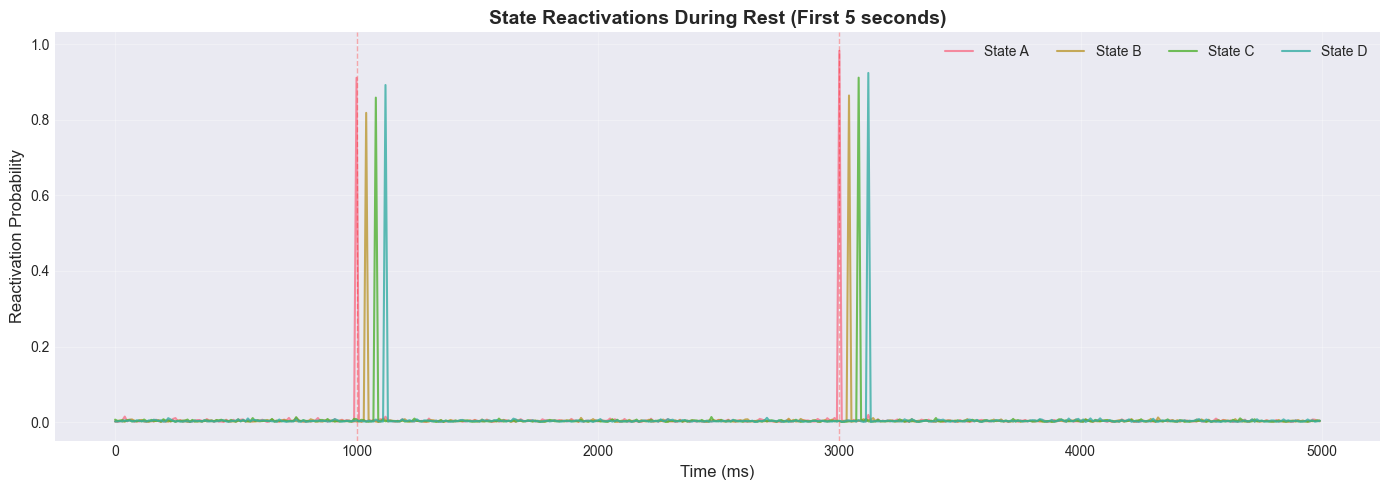

Reactivation visualization saved!


In [6]:
# Decode states from resting data
print("\nDecoding states from resting data...")
reactivation_probs = decoder.decode_states(X_rest)
print(f"  Reactivation matrix shape: {reactivation_probs.shape}")
print(f"  Time resolution: 10ms")

# Visualize reactivations
fig, ax = plt.subplots(figsize=(14, 5))

# Plot first 5 seconds
time_window = slice(0, 500)
time_ms = np.arange(500) * 10

for state in range(n_states):
    ax.plot(time_ms, reactivation_probs[time_window, state],
           label=f'State {state_names[state]}', linewidth=1.5, alpha=0.8)

# Mark embedded replay events
for rt in replay_times:
    if rt < 500:
        ax.axvline(x=rt*10, color='red', linestyle='--', alpha=0.3, linewidth=1)

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('Reactivation Probability', fontsize=12)
ax.set_title('State Reactivations During Rest (First 5 seconds)', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', ncol=4)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('reactivation_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

print("Reactivation visualization saved!")

Transition matrix (A→B→C→D):
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]]


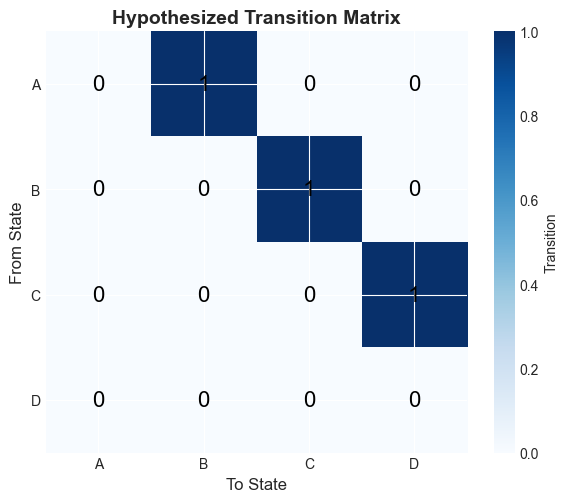

In [7]:
# Define transition matrix for A→B→C→D using the helper function
transition_matrix = create_linear_transition_matrix(n_states)

print("Transition matrix (A→B→C→D):")
print(transition_matrix)

# Visualize transition matrix
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(transition_matrix, cmap='Blues', vmin=0, vmax=1)
ax.set_xticks(range(n_states))
ax.set_yticks(range(n_states))
ax.set_xticklabels(state_names)
ax.set_yticklabels(state_names)
ax.set_xlabel('To State', fontsize=12)
ax.set_ylabel('From State', fontsize=12)
ax.set_title('Hypothesized Transition Matrix', fontsize=14, fontweight='bold')

# Add text annotations
for i in range(n_states):
    for j in range(n_states):
        text = ax.text(j, i, int(transition_matrix[i, j]),
                      ha="center", va="center", color="black", fontsize=16)

plt.colorbar(im, ax=ax, label='Transition')
plt.tight_layout()
plt.savefig('transition_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Compute sequenceness
print("Computing sequenceness...")
sequenceness, time_lags = decoder.compute_sequenceness(
    reactivation_probs, transition_matrix, alpha_control=False
)

# Find peak
peak_idx = np.argmax(np.abs(sequenceness))
peak_lag = time_lags[peak_idx]
peak_value = sequenceness[peak_idx]

print(f"\nResults:")
print(f"  Peak sequenceness: {peak_value:.4f}")
print(f"  Peak lag: {peak_lag}ms")
print(f"  Expected lag: 40ms (embedded in data)")
print(f"  Direction: {'Forward' if peak_value > 0 else 'Backward'}")

Computing sequenceness...

Results:
  Peak sequenceness: 0.9927
  Peak lag: 40ms
  Expected lag: 40ms (embedded in data)
  Direction: Forward


In [9]:
# Run permutation test
print("\nRunning permutation test (500 permutations)...")
print("This may take a minute...")

p_values, threshold, true_seq = decoder.permutation_test(
    reactivation_probs, transition_matrix, n_permutations=500, alpha_control=False
)

significant_lags = time_lags[p_values < 0.05]
print(f"\nStatistical Results:")
print(f"  Significance threshold: {threshold:.4f}")
print(f"  Number of significant lags: {len(significant_lags)}")
if len(significant_lags) > 0:
    print(f"  Significant time lags: {significant_lags}ms")
    print(f"  Peak p-value: {p_values[peak_idx]:.4f}")


Running permutation test (500 permutations)...
This may take a minute...

Statistical Results:
  Significance threshold: 0.6722
  Number of significant lags: 1
  Significant time lags: [40]ms
  Peak p-value: 0.0000


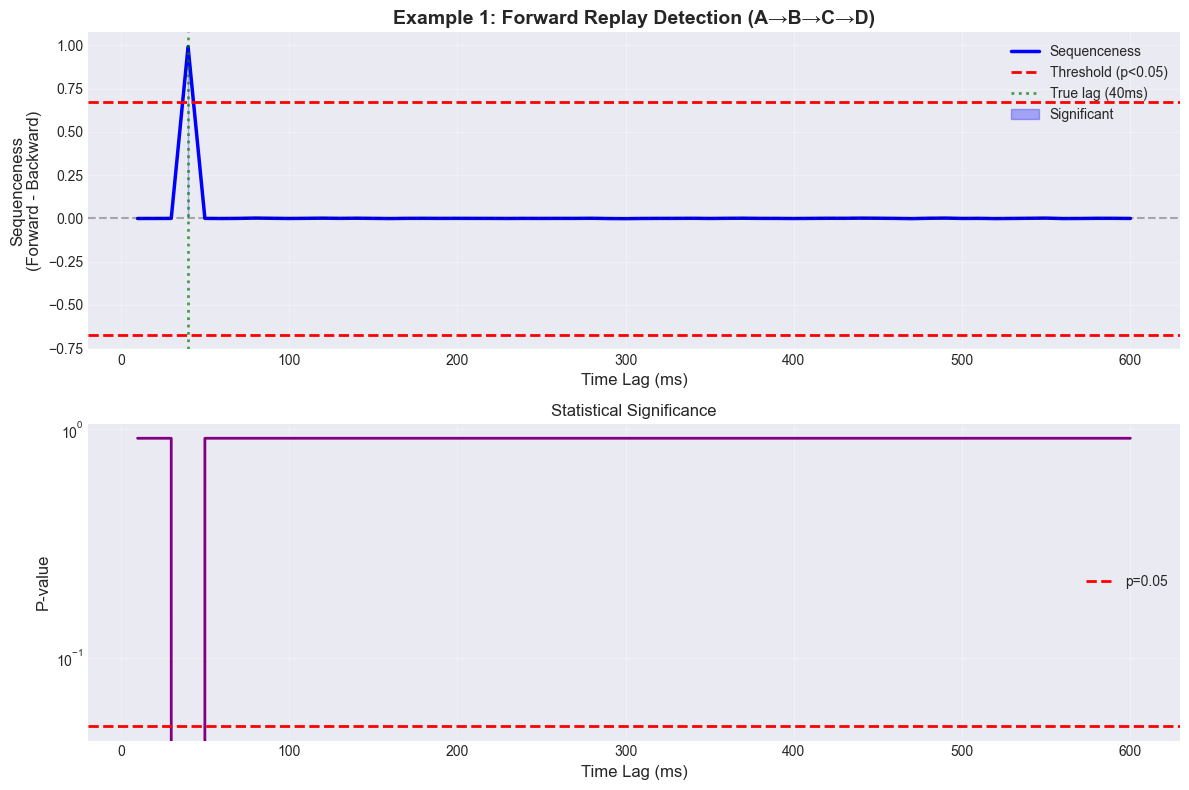


Sequenceness analysis complete!


In [11]:
# Visualize sequenceness results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Sequenceness
ax1.plot(time_lags, sequenceness, 'b-', linewidth=2.5, label='Sequenceness')
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.3)
ax1.axhline(y=threshold, color='r', linestyle='--', linewidth=2, label=f'Threshold (p<0.05)')
ax1.axhline(y=-threshold, color='r', linestyle='--', linewidth=2)
ax1.axvline(x=40, color='green', linestyle=':', linewidth=2, alpha=0.7, label='True lag (40ms)')
ax1.fill_between(time_lags, 0, sequenceness, where=(sequenceness > threshold),
                 alpha=0.3, color='blue', label='Significant')
ax1.set_xlabel('Time Lag (ms)', fontsize=12)
ax1.set_ylabel('Sequenceness\n(Forward - Backward)', fontsize=12)
ax1.set_title('Example 1: Forward Replay Detection (A→B→C→D)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: P-values
ax2.plot(time_lags, p_values, 'purple', linewidth=2)
ax2.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')
ax2.fill_between(time_lags, 0, p_values, where=(p_values < 0.05),
                alpha=0.3, color='purple')
ax2.set_xlabel('Time Lag (ms)', fontsize=12)
ax2.set_ylabel('P-value', fontsize=12)
ax2.set_title('Statistical Significance', fontsize=12)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('sequenceness_example1.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSequenceness analysis complete!")

## Part 1.1: Classifier Performance Validation with Permutation Test

Following Figure S3 from the paper, we validate classifier performance using a permutation test. This tests whether classifiers can decode stimuli better than chance by randomly permuting labels.

In [ ]:
# Create test data to validate classifier performance
print("Creating test data for permutation test...")
n_test_trials = 100
X_test = np.random.randn(n_test_trials, n_timepoints_per_trial, n_sensors) * 0.5
y_test = np.random.randint(0, n_states, n_test_trials)

# Add signal at 200ms for each state (same pattern as training)
for trial in range(n_test_trials):
    state = y_test[trial]
    X_test[trial, time_idx, state*10:(state+1)*10] += 2.0

print(f"Test data shape: {X_test.shape}")
print(f"Running permutation test with 1000 permutations...")
print("This will take a minute...")

# Run the permutation test
true_accuracy, perm_accuracies, p_value, threshold = decoder.permutation_test_decoding(
    X_test, y_test, n_permutations=1000
)

print(f"\nResults:")
print(f"  True accuracy: {true_accuracy:.4f}")
print(f"  Permutation threshold (95th percentile): {threshold:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

NameError: name 'perm_accuracies' is not defined

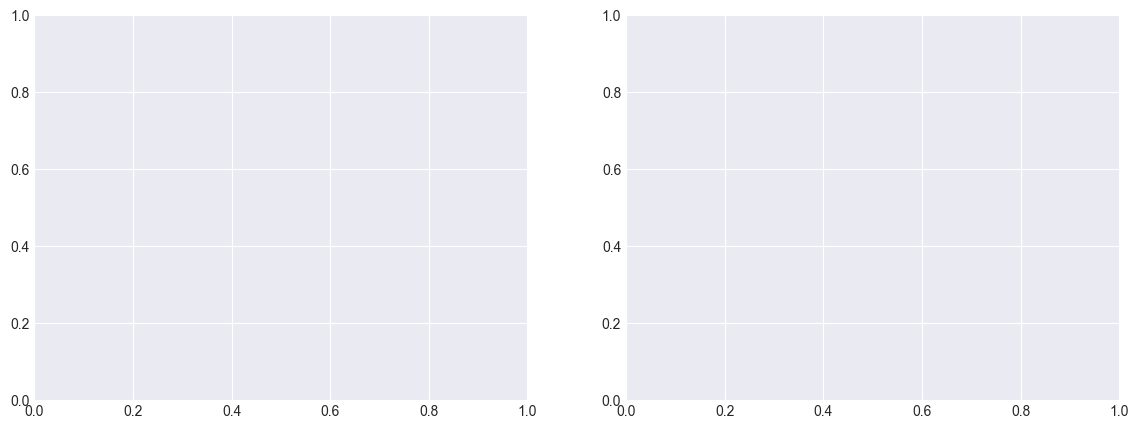

In [12]:
# Visualize results similar to Figure S3 panels c and d
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Panel c: Histogram of permutation distribution with true accuracy
ax1.hist(perm_accuracies, bins=50, alpha=0.7, color='gray', edgecolor='black', label='Null distribution')
ax1.axvline(true_accuracy, color='red', linewidth=3, label=f'True accuracy ({true_accuracy:.3f})', linestyle='-')
ax1.axvline(threshold, color='blue', linewidth=2, label=f'Threshold p<0.05 ({threshold:.3f})', linestyle='--')
ax1.set_xlabel('Classification Accuracy', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.set_title('Panel C: Permutation Test Distribution\nClassifier Performance vs Chance', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10)
ax1.grid(True, alpha=0.3, axis='y')

# Add text annotation
ax1.text(0.98, 0.97, f'p = {p_value:.4f}\n{n_test_trials} test trials\n{len(perm_accuracies)} permutations',
         transform=ax1.transAxes, fontsize=10, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Panel d: CDF plot showing where true accuracy falls in distribution
sorted_perms = np.sort(perm_accuracies)
cdf = np.arange(1, len(sorted_perms) + 1) / len(sorted_perms)

ax2.plot(sorted_perms, cdf, 'b-', linewidth=2, label='Cumulative distribution')
ax2.axvline(true_accuracy, color='red', linewidth=3, label=f'True accuracy', linestyle='-')
ax2.axhline(0.95, color='blue', linewidth=2, label='95th percentile', linestyle='--')
ax2.axvline(threshold, color='blue', linewidth=2, linestyle='--')
ax2.fill_betweenx([0, 1], threshold, sorted_perms.max(), alpha=0.2, color='green', label='Significant region')

ax2.set_xlabel('Classification Accuracy', fontsize=12)
ax2.set_ylabel('Cumulative Probability', fontsize=12)
ax2.set_title('Panel D: Cumulative Distribution\nTrue Accuracy vs Null Distribution', fontsize=13, fontweight='bold')
ax2.legend(loc='lower right', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.savefig('permutation_test_figure_s3.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure similar to Figure S3 saved!")

## Part 2: Example 2 - Reverse Replay After Reward

The paper showed that replay reverses direction after reward. Let's simulate this phenomenon.

In [16]:
# Simulate resting state with REVERSE replay (D→C→B→A)
print("Simulating resting state with REVERSE replay (D→C→B→A)...")
X_rest_reverse = np.random.randn(n_rest_timepoints, n_sensors) * 0.3

# Embed REVERSE sequence D→C→B→A at 40ms lag
reverse_sequence = [3, 2, 1, 0]  # D→C→B→A
replay_times_reverse = []

for start_time in range(100, n_rest_timepoints - 100, 200):
    replay_times_reverse.append(start_time)
    for step, state in enumerate(reverse_sequence):
        time_point = start_time + step * lag_samples
        if time_point < n_rest_timepoints:
            X_rest_reverse[time_point, state*10:(state+1)*10] += 1.5

print(f"  Embedded {len(replay_times_reverse)} REVERSE replay events")
print(f"  Replay lag: 40ms between states")

# Decode reverse replay
print("\nDecoding reverse replay...")
reactivation_probs_reverse = decoder.decode_states(X_rest_reverse)

# Compute sequenceness for reverse replay
print("Computing sequenceness for reverse replay...")
sequenceness_reverse, _ = decoder.compute_sequenceness(
    reactivation_probs_reverse, transition_matrix, alpha_control=False
)

# Find peak
peak_idx_reverse = np.argmax(np.abs(sequenceness_reverse))
peak_lag_reverse = time_lags[peak_idx_reverse]
peak_value_reverse = sequenceness_reverse[peak_idx_reverse]

print(f"\nResults:")
print(f"  Peak sequenceness: {peak_value_reverse:.4f}")
print(f"  Peak lag: {peak_lag_reverse}ms")
print(f"  Direction: {'Forward' if peak_value_reverse > 0 else 'Backward (Reverse)'}")

Simulating resting state with REVERSE replay (D→C→B→A)...
  Embedded 14 REVERSE replay events
  Replay lag: 40ms between states

Decoding reverse replay...
Computing sequenceness for reverse replay...

Results:
  Peak sequenceness: -1.0000
  Peak lag: 40ms
  Direction: Backward (Reverse)


## Part 3: Example 3 - Multiple Sequences

Real experiments often have multiple possible sequences. Let's test with two interleaved sequences.

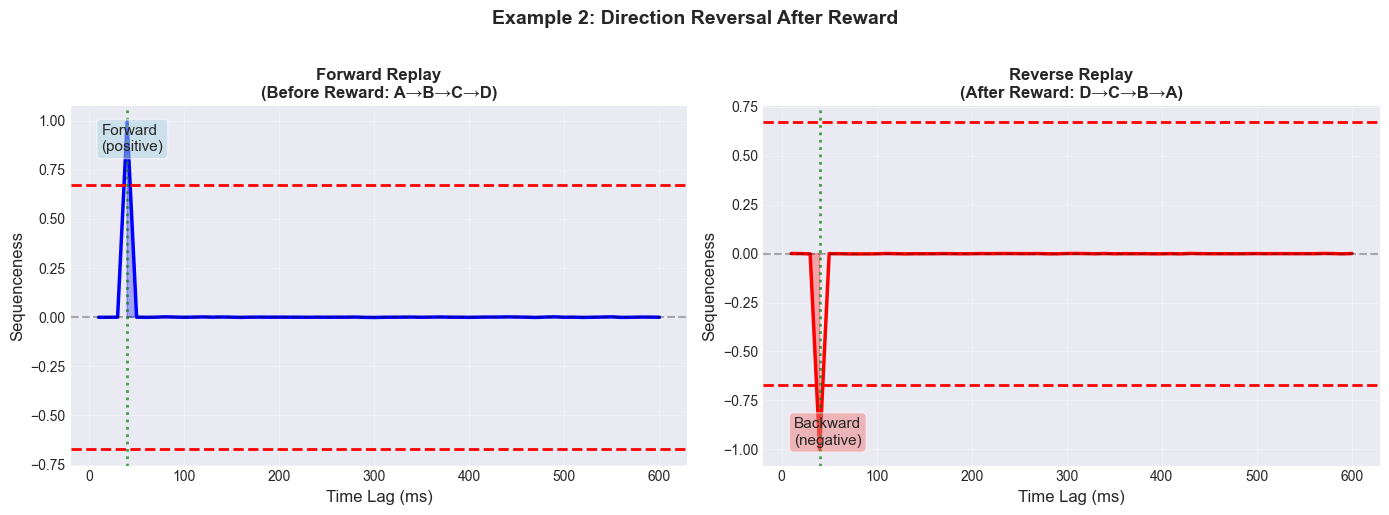


Comparison complete!


In [17]:
# Compare forward and reverse replay
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Forward replay
axes[0].plot(time_lags, sequenceness, 'b-', linewidth=2.5)
axes[0].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[0].axhline(y=threshold, color='r', linestyle='--', linewidth=2)
axes[0].axhline(y=-threshold, color='r', linestyle='--', linewidth=2)
axes[0].axvline(x=40, color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[0].fill_between(time_lags, 0, sequenceness, where=(sequenceness > 0),
                     alpha=0.3, color='blue')
axes[0].set_xlabel('Time Lag (ms)', fontsize=12)
axes[0].set_ylabel('Sequenceness', fontsize=12)
axes[0].set_title('Forward Replay\n(Before Reward: A→B→C→D)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, 'Forward\n(positive)', transform=axes[0].transAxes,
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

# Reverse replay
axes[1].plot(time_lags, sequenceness_reverse, 'r-', linewidth=2.5)
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].axhline(y=threshold, color='r', linestyle='--', linewidth=2)
axes[1].axhline(y=-threshold, color='r', linestyle='--', linewidth=2)
axes[1].axvline(x=40, color='green', linestyle=':', linewidth=2, alpha=0.7)
axes[1].fill_between(time_lags, 0, sequenceness_reverse, where=(sequenceness_reverse < 0),
                     alpha=0.3, color='red')
axes[1].set_xlabel('Time Lag (ms)', fontsize=12)
axes[1].set_ylabel('Sequenceness', fontsize=12)
axes[1].set_title('Reverse Replay\n(After Reward: D→C→B→A)', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.05, 'Backward\n(negative)', transform=axes[1].transAxes,
            fontsize=11, verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.suptitle('Example 2: Direction Reversal After Reward', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('sequenceness_example2_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison complete!")

In [18]:
# Use 8 states for two sequences
n_states_multi = 8
decoder_multi = MultivariateReplayDecoder(n_states=n_states_multi, max_lag_ms=600)

# Create training data for 8 states
print("Creating training data for 8 states (2 sequences)...")
X_train_multi = np.random.randn(400, n_timepoints_per_trial, n_sensors) * 0.5
y_train_multi = np.random.randint(0, n_states_multi, 400)

# Add signal for each state
for trial in range(400):
    state = y_train_multi[trial]
    X_train_multi[trial, time_idx, state*12:(state+1)*12] += 2.0

# Train decoder
print("Training decoder for 8 states...")
decoder_multi.train_classifiers(X_train_multi, y_train_multi, time_point_ms=200)

# Define two sequences: Seq1 (0→1→2→3) and Seq2 (4→5→6→7)
transition_matrix_seq1 = np.zeros((8, 8))
transition_matrix_seq1[0, 1] = 1  # 0→1
transition_matrix_seq1[1, 2] = 1  # 1→2
transition_matrix_seq1[2, 3] = 1  # 2→3

transition_matrix_seq2 = np.zeros((8, 8))
transition_matrix_seq2[4, 5] = 1  # 4→5
transition_matrix_seq2[5, 6] = 1  # 5→6
transition_matrix_seq2[6, 7] = 1  # 6→7

print("\nSequence 1: States 0→1→2→3")
print("Sequence 2: States 4→5→6→7")

Creating training data for 8 states (2 sequences)...
Training decoder for 8 states...

Sequence 1: States 0→1→2→3
Sequence 2: States 4→5→6→7


/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(
/Users/fpbattaglia/src/DecodeTest/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_rat

In [19]:
# Simulate rest with ONLY Sequence 1 replay
print("\nSimulating rest with Sequence 1 replay only...")
X_rest_multi = np.random.randn(n_rest_timepoints, n_sensors) * 0.3

# Embed Sequence 1: 0→1→2→3
seq1 = [0, 1, 2, 3]
for start_time in range(100, n_rest_timepoints - 100, 200):
    for step, state in enumerate(seq1):
        time_point = start_time + step * lag_samples
        if time_point < n_rest_timepoints:
            X_rest_multi[time_point, state*12:(state+1)*12] += 1.5

# Decode
print("Decoding...")
reactivation_probs_multi = decoder_multi.decode_states(X_rest_multi)

# Compute sequenceness for both sequences
print("\nComputing sequenceness for both sequences...")
seq1_sequenceness, _ = decoder_multi.compute_sequenceness(
    reactivation_probs_multi, transition_matrix_seq1
)
seq2_sequenceness, _ = decoder_multi.compute_sequenceness(
    reactivation_probs_multi, transition_matrix_seq2
)

# Compare peaks
peak1 = np.max(np.abs(seq1_sequenceness))
peak2 = np.max(np.abs(seq2_sequenceness))

print(f"\nResults:")
print(f"  Sequence 1 peak: {peak1:.4f}")
print(f"  Sequence 2 peak: {peak2:.4f}")
print(f"  Ratio (Seq1/Seq2): {peak1/peak2:.2f}")


Simulating rest with Sequence 1 replay only...
Decoding...

Computing sequenceness for both sequences...

Results:
  Sequence 1 peak: 0.9923
  Sequence 2 peak: 0.0268
  Ratio (Seq1/Seq2): 37.00
